# CSE206 GroupF
## Building an interactive chatbot


<img src="https://media4.giphy.com/media/VdoNp9BUcnXRowPaeW/giphy.gif?cid=49972e292ngfnacddfo7876rqpeju7jmwcyysvmu8snmjdwd&rid=giphy.gif&ct=" style="margin:auto"/>

## Section1: Introduction

![General](Mindmap/General.png)


Chatbots are a very popular tool for costumer services and eCommerce. For this project, we want to use this tool to engage user in a human conversation. Our chatbot is going to have many purposes: make the user feel less lonely by text messages, tell jokes and make him laugh by using memes, help him learn a new language by translating, and why not become the first therapeutic chatbot(further more).  

In other words, we are aiming to train a "Transformer model" to be an interactive chatbot. Knowledge of transformer, attention and text generation ect are needed for us to achieve our goal.


## Section2: Transformer-based chatbot

![Intro](./Mindmap/Intro.png)



## Comparison with RNN

![RNN](https://www.georgeho.org/assets/images/rnn-unrolled.png)
RNN diagram. Source:  [Chris Olah](https://colah.github.io/posts/2015-08-Understanding-LSTMs/).

- RNN processes data sequentially, so it is not very efficient in handling long sentences (sequences of words). The model tends to forget the contents of the distant position.

- Transformers work on the whole sequence, which let them learn long-range dependencies so that it can be processed in parallel, making training much faster.


## Overall view of Transformer


![Transformer](https://codeantenna.com/image/https://img-blog.csdnimg.cn/20210506014637997.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3FxXzMzMzMxNDUx,size_16,color_FFFFFF,t_70#pic_center)

Encoders and Decoders stacked embedding Source: CodeAntenna

In [97]:
from __future__ import absolute_import, division, print_function, unicode_literals

import sys

import tensorflow as tf

tf.random.set_seed(1234)
AUTO = tf.data.experimental.AUTOTUNE

#!pip install tensorflow-datasets==4.1.0
import tensorflow_datasets as tfds

import os
import re
import numpy as np
from time import time
import matplotlib.pyplot as plt

print("Tensorflow version {}".format(tf.__version__))

Tensorflow version 2.8.0


In [98]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU {}'.format(tpu.cluster_spec().as_dict()['worker']))
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: {}".format(strategy.num_replicas_in_sync))

REPLICAS: 1


## Hyperparameters

In this part, we decided to fix some parameters such as batch_size, num_layers, and others to make our model relatively fast and easy to train and to test.

In [99]:
# Maximum sentence length
MAX_LENGTH = 40

# Maximum number of samples to preprocess
MAX_SAMPLES = 50000

# For tf.data.Dataset
BATCH_SIZE = 64 * strategy.num_replicas_in_sync
BUFFER_SIZE = 20000

# For Transformer
NUM_LAYERS = 2
D_MODEL = 256
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.1

EPOCHS = 100

## Dataset
### Load Data
Our dataset is provided by [Cornell Movie-Dialogs Corpus](https://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html), which contains more than 220 thousands conversational exchanges between more than 10k pairs of movie and TV shows characters.

- `movie_conversations.txt` contains list of the conversation IDs
- `movie_lines.text` contains the text of assoicated with each conversation ID.

In [100]:
path_to_zip = tf.keras.utils.get_file(
    'cornell_movie_dialogs.zip',
    origin=
    'http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip',
    extract=True)

path_to_dataset = os.path.join(
    os.path.dirname(path_to_zip), "cornell movie-dialogs corpus")

path_to_movie_lines = os.path.join(path_to_dataset, 'movie_lines.txt')
path_to_movie_conversations = os.path.join(path_to_dataset,
                                           'movie_conversations.txt')

print(path_to_movie_lines)

/Users/mac/.keras/datasets/cornell movie-dialogs corpus/movie_lines.txt


### Prepare the data 

In order to prepare and prepross our dataset, we needed to make sure that it is all conform to the correct languistic and lexical english vocabulary by substituting different unformal forms to formal ones and making sure the punctuation does not create any confusion or separated similar words (check examples). 


We also thought that extracting questions and answers from a limited number of samples (MAX_SAMPLES) of conversation pairs 

In [101]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    # removing contractions
    sentence = re.sub(r"i'm", "i am", sentence)
    sentence = re.sub(r"he's", "he is", sentence)
    sentence = re.sub(r"she's", "she is", sentence)
    sentence = re.sub(r"it's", "it is", sentence)
    sentence = re.sub(r"that's", "that is", sentence)
    sentence = re.sub(r"what's", "that is", sentence)
    sentence = re.sub(r"where's", "where is", sentence)
    sentence = re.sub(r"how's", "how is", sentence)
    sentence = re.sub(r"\'ll", " will", sentence)
    sentence = re.sub(r"\'ve", " have", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"\'d", " would", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"won't", "will not", sentence)
    sentence = re.sub(r"can't", "cannot", sentence)
    sentence = re.sub(r"n't", " not", sentence)
    sentence = re.sub(r"n'", "ng", sentence)
    sentence = re.sub(r"'bout", "about", sentence)
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
    sentence = sentence.strip()
    return sentence


def load_conversations():
    # dictionary of line id to text
    id2line = {}
    with open(path_to_movie_lines, errors='ignore') as file:
        lines = file.readlines()
    for line in lines:
        parts = line.replace('\n', '').split(' +++$+++ ')
        id2line[parts[0]] = parts[4]

    inputs, outputs = [], []
    with open(path_to_movie_conversations, 'r') as file:
        lines = file.readlines()
    for line in lines:
        parts = line.replace('\n', '').split(' +++$+++ ')
        # get conversation in a list of line ID
        conversation = [line[1:-1] for line in parts[3][1:-1].split(', ')]
        for i in range(len(conversation) - 1):
            inputs.append(preprocess_sentence(id2line[conversation[i]]))
            outputs.append(preprocess_sentence(id2line[conversation[i + 1]]))
            if len(inputs) >= MAX_SAMPLES:
                return inputs, outputs
    return inputs, outputs


questionRAW, answerRAW = load_conversations()

print('Sample question: {}'.format(questionRAW[0]))
print('Sample answer: {}'.format(answerRAW[0]))

Sample question: can we make this quick ? roxanne korrine and andrew barrett are having an incredibly horrendous public break up on the quad . again .
Sample answer: well , i thought we would start with pronunciation , if that is okay with you .


### Tokenizer 



![Tokenizer](./Mindmap/Tokenizer.png)



In [102]:
## Build tokenizer using tfds for both questions and answers
#tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
#    questionRAW + answerRAW, target_vocab_size=2**13)

## Save the Tokenizer
#tokenizer.save_to_file('Transformer.tokenizer')

In [237]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.load_from_file('Transformer.tokenizer')

# Define start and end token to indicate the start and end of a sentence
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# Vocabulary size plus start and end token
VOCAB_SIZE = tokenizer.vocab_size + 2

print(f'VOCAB_SIZE: {tokenizer.vocab_size}, START_TOKEN: {START_TOKEN}, END_TOKEN: {END_TOKEN}')

print('\nThe first 15 elements in the Tokenizer (indeed based on frequency)')
for i in range(15):
    print(i, tokenizer.decode([i]))
    
print('\n',tokenizer.encode('pneumonoultramicroscopicsilicovolcanoconiosis'))
print(tokenizer.decode([8133, 4026, 626, 2154, 1612, 2809, 868, 3716, 7922, 5316, 2834, 1115, 3822, 518, 1167, 1660, 5477, 8136]), '\n')


print(tokenizer.encode('我'))
print(tokenizer.decode([8251, 8157, 8166]), '\n')

VOCAB_SIZE: 8277, START_TOKEN: [8277], END_TOKEN: [8278]

The first 15 elements in the Tokenizer (indeed based on frequency)
0 
1  .
2  . 
3  , 
4 i 
5 you 
6 the 
7  ?
8 to 
9 is 
10 a 
11 not 
12 it 
13 do 
14 and 

 [8133, 4026, 626, 2154, 1612, 2809, 868, 3716, 7922, 5316, 2834, 1115, 3822, 518, 1167, 1660, 5477, 8136]
pneumonoultramicroscopicsilicovolcanoconiosis 

[8251, 8157, 8166]
我 



The following shows how a question is tokenized:

In [145]:
print('Tokenized sample question: {}\n'.format(tokenizer.encode(questionRAW[151])))
print(questionRAW[151],'\n')
print(f'Frist encode, and then decode: \n{tokenizer.decode(tokenizer.encode(questionRAW[151]))}')

Tokenized sample question: [5, 47, 5554, 7]

you know french ? 

Frist encode, and then decode: 
you know french ?


In [105]:
# Tokenize, filter and pad sentences
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []

    for (sentence1, sentence2) in zip(inputs, outputs):
        # tokenize sentence
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
        # check tokenized sentence max length
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)

    # pad tokenized sentences
    # see https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

    return tokenized_inputs, tokenized_outputs


questions, answers = tokenize_and_filter(questionRAW, answerRAW)

In [106]:
print('Vocab size: {}'.format(VOCAB_SIZE))
print('Number of samples: {}'.format(len(questions)))

Vocab size: 8279
Number of samples: 44131


## Construct Dataset

![Dataset](./Mindmap/Dataset.png)


Target is divided into `decoder_inputs` which padded as an input to the decoder and `cropped_targets` for calculating our loss and accuracy.



In [188]:
#print(questions, questions.shape)
#print(answers, answers.shape)

#print(answers[151, :-1], answers[:, :-1].shape)
#print(tokenizer.decode([5, 385, 72, 64, 38, 98, 7]))
#print(answers[151, 1:], answers[:, 1:].shape)

In [108]:
# decoder inputs use the previous target as input
# remove START_TOKEN from targets
dataset = tf.data.Dataset.from_tensor_slices((
    # Cornell dataset for decoder input
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    # Cropped target: removing START_TOKEN to calculate loss and accuracy
    {
        'outputs': answers[:, 1:]
    },
))
#Caches the elements in this dataset
dataset = dataset.cache() 
#Randomly shuffles the elements of this dataset.
dataset = dataset.shuffle(BUFFER_SIZE) 
#Combines consecutive elements of this dataset into batches
dataset = dataset.batch(BATCH_SIZE)
#Creates a `Dataset` that prefetches elements from this dataset.
#Prefetching solves the inefficiencies from naive approach
#as it aimsto overlap the preprocessing and model execution of the training step
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

## Attention using Scaled-dot product



![Attention](./Mindmap/Attention.png)

`

Students work on their homeworks because <b>they</b> are difficult.

Students work on their homeworks because <b>they</b> feel like to work.

`


The scaled dot-product attention function used by the transformer takes three inputs: Q (query), K (key), V (value). The equation used to calculate the attention weights is:


$$\Large{Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$



For each token $i$, the input word embedding $x_i$ is multiplied with each of the three weight matrices to produce a query vector $q_i = x_i*Q$, a key vector $k_i = x_i*K$, and a value vector $v_i=x_i*V$. 

The matrices $Q$, $K$ and $V$ are defined as the matrices where the $i$ th rows are vectors $q_i$, $k_i$, and $v_i$ respectively.

The attention calculation for all tokens can be expressed as one large matrix calculation using the softmax function, which is useful for training due to computational matrix operation optimizations that quickly compute matrix operations.

The element of the ith row and jth column represents the attention weight $a_{ij}$ from token $i$ to token $j$.
The attention weights are divided by the square root of the dimension of the key vectors, $\sqrt{d_k}$, also called the depth which stabilizes gradients during training.


![Computing Attention](https://miro.medium.com/max/1000/1*BFteTbyGLg5T6x_VcOuHFg.png)

Image by Ketan Doshi

In [109]:
def scaled_dot_product_attention(query, key, value, mask):
    """Calculate the attention weights. """
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # scale matmul_qk
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # add the mask to zero out padding tokens
    if mask is not None:
        logits += (mask * -1e9)

    # softmax is normalized on the last axis (seq_len_k)
    attention_weights = tf.nn.softmax(logits, axis=-1)

    output = tf.matmul(attention_weights, value)

    return output

## Multi-head Attention

 Multi-head Attention is a module for attention mechanisms which runs through an attention mechanism several times in parallel. one set of (Q, K, V) is called attention head. The Attention module splits its Query, Key, and Value parameters N-ways and passes each split independently through a separate Head.

 All of these similar Attention calculations are then combined together to produce a final Attention score using scaled-dot-product.
 
 This is called Multi-head attention and gives the Transformer greater power to encode multiple relationships and nuances for each word.

<!--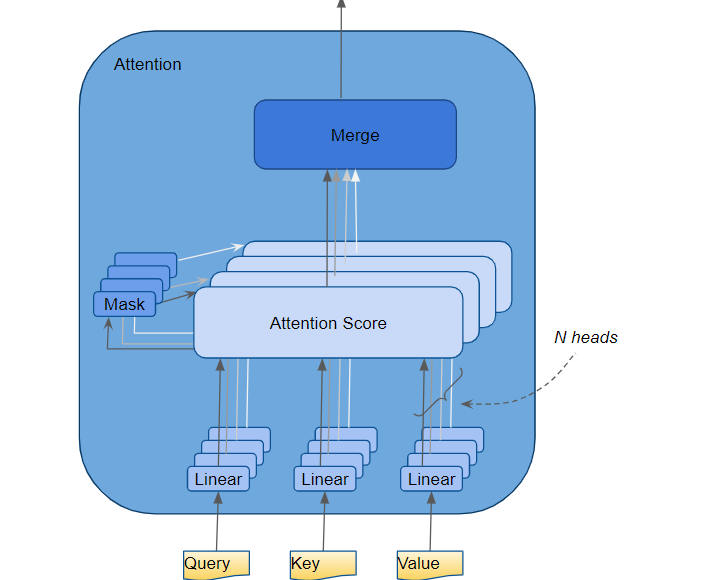-->

![multiple%20head.png](https://miro.medium.com/max/1400/1*DKNIOlVfbh9K1EqU5iDJKA.png)

Source: CodeAntenna

In [110]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def get_config(self):
            config = super(MultiHeadAttention,self).get_config()
            config.update({
                'num_heads':self.num_heads,
                'd_model':self.d_model,
            })
            return config

    def split_heads(self, inputs, batch_size):
        # reshape
        inputs = tf.keras.layers.Lambda(lambda inputs:tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth)))(inputs)
        # transpose
        return tf.keras.layers.Lambda(lambda inputs: tf.transpose(inputs, perm=[0, 2, 1, 3]))(inputs)

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # linear layers
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # split heads
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # scaled dot-product attention
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)
        scaled_attention = tf.keras.layers.Lambda(lambda scaled_attention: tf.transpose(
            scaled_attention, perm=[0, 2, 1, 3]))(scaled_attention)
        # dim_0 -> dim_0, dim_1 -> dim_2, dim_2 -> dim_1, dim_3 -> dim_3.

        # concatenation of heads
        concat_attention = tf.keras.layers.Lambda(lambda scaled_attention: tf.reshape(scaled_attention,
                                    (batch_size, -1, self.d_model)))(scaled_attention)

        # final linear layer
        outputs = self.dense(concat_attention)

        return outputs

## Transformer
### Mask 0 as 1

![Masking](./Mindmap/Masking.png)

Now that all samples have a unifrom length, the model must be informed that some data should be ignored.


In [111]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [112]:
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


## Look ahead mask

To predict the third word, only the first and second word will be used

0 values always become 1

In [113]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

In [114]:
print(create_look_ahead_mask(tf.constant([[1, 2, 3]])))
# in the ouput of look_ahead_mask, 0 means consider/preserve, 1 means ignore/hide (intermediate)

tf.Tensor(
[[[[0. 1. 1.]
   [0. 0. 1.]
   [0. 0. 0.]]]], shape=(1, 1, 3, 3), dtype=float32)


In [193]:
print(create_padding_mask(create_look_ahead_mask(tf.constant([[1, 2, 3]]))))
# after padding mask, now we can directly make matrix multiplicatoin because 0 means ignore now

tf.Tensor(
[[[[[[1. 0. 0.]
     [1. 1. 0.]
     [1. 1. 1.]]]]]], shape=(1, 1, 1, 1, 3, 3), dtype=float32)


## Positional encoding

![Position](./Mindmap/PositionalEncoding.png)


`

I do <b>not</b> like the story, but I do like the movie.

I do like the story, but I do <b>not</b> like the movie.

`


Since transformer model doesn't contain any recurrence or convolution, positional encoding is added to give the model some information about the relative position of the words in the sentence.


$$\Large{PE_{(pos, 2i)} = \sin(\frac{pos} { 10000^{ \frac{2i} { d_{model} } } })} $$
$$\Large{PE_{(pos, 2i+1)} = \cos(\frac{pos} { 10000^{ \frac{2i} { d_{model} } } } )} $$



The positional encoding vector is added to the embedding vector. Embeddings represent a token in a d-dimensional space where tokens with similar meaning will be closer to each other.
- But the embeddings do not encode the relative position of words in a sentence.
- So after adding the positional encoding, words will be closer to each other based on the *similarity of their meaning and their position in the sentence*, in the d-dimensional space.

In [115]:
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_config(self):

            config = super(PositionalEncoding, self).get_config()
            config.update({
                'position': self.position,
                'd_model': self.d_model,

            })
            return config

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)
        # apply sin to even index in the array
        sines = tf.math.sin(angle_rads[:, 0::2])
        # apply cos to odd index in the array
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

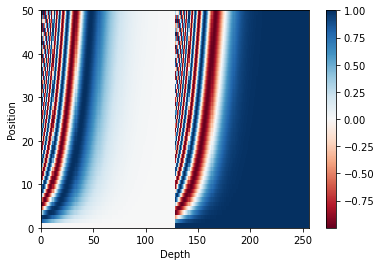

In [199]:
sample_pos_encoding = PositionalEncoding(50, 256)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 256))
plt.ylabel('Position')
plt.colorbar()
plt.show()

The graph is basically an illustration of our matrix. Depth represents the dimension of the matrix and the position represents the position of the word in the sentence. We can observe that starting from dimension 100 until 250 and from 330 to 512 the indices of our matrix are the same 0 and 1 respectively.

## Encoder layer
Each encoder layer consists of sublayers:

1. Padding: we mask the parts that we don't want the Network to take into account.

2. Multi-Head Attention is applied to the sentence itself (self-attention) in order to focus on the most relevant parts of the input sequence. 

3. Dense layers provides information about embedding position

4. Dropout and normalization (mean 0 and standard deviation 1) are applied, so transformer can be trained easier.


In [117]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")({
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': padding_mask
        })
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
	# input/gradient signal is able to pass back thanks to [inputs,attention] to solve vanishing gradient
    add_attention = tf.keras.layers.add([inputs,attention])
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    # input/gradient signal is able to pass back thanks to [inputs,attention] to solve vanishing gradient
    add_attention = tf.keras.layers.add([attention,outputs])
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

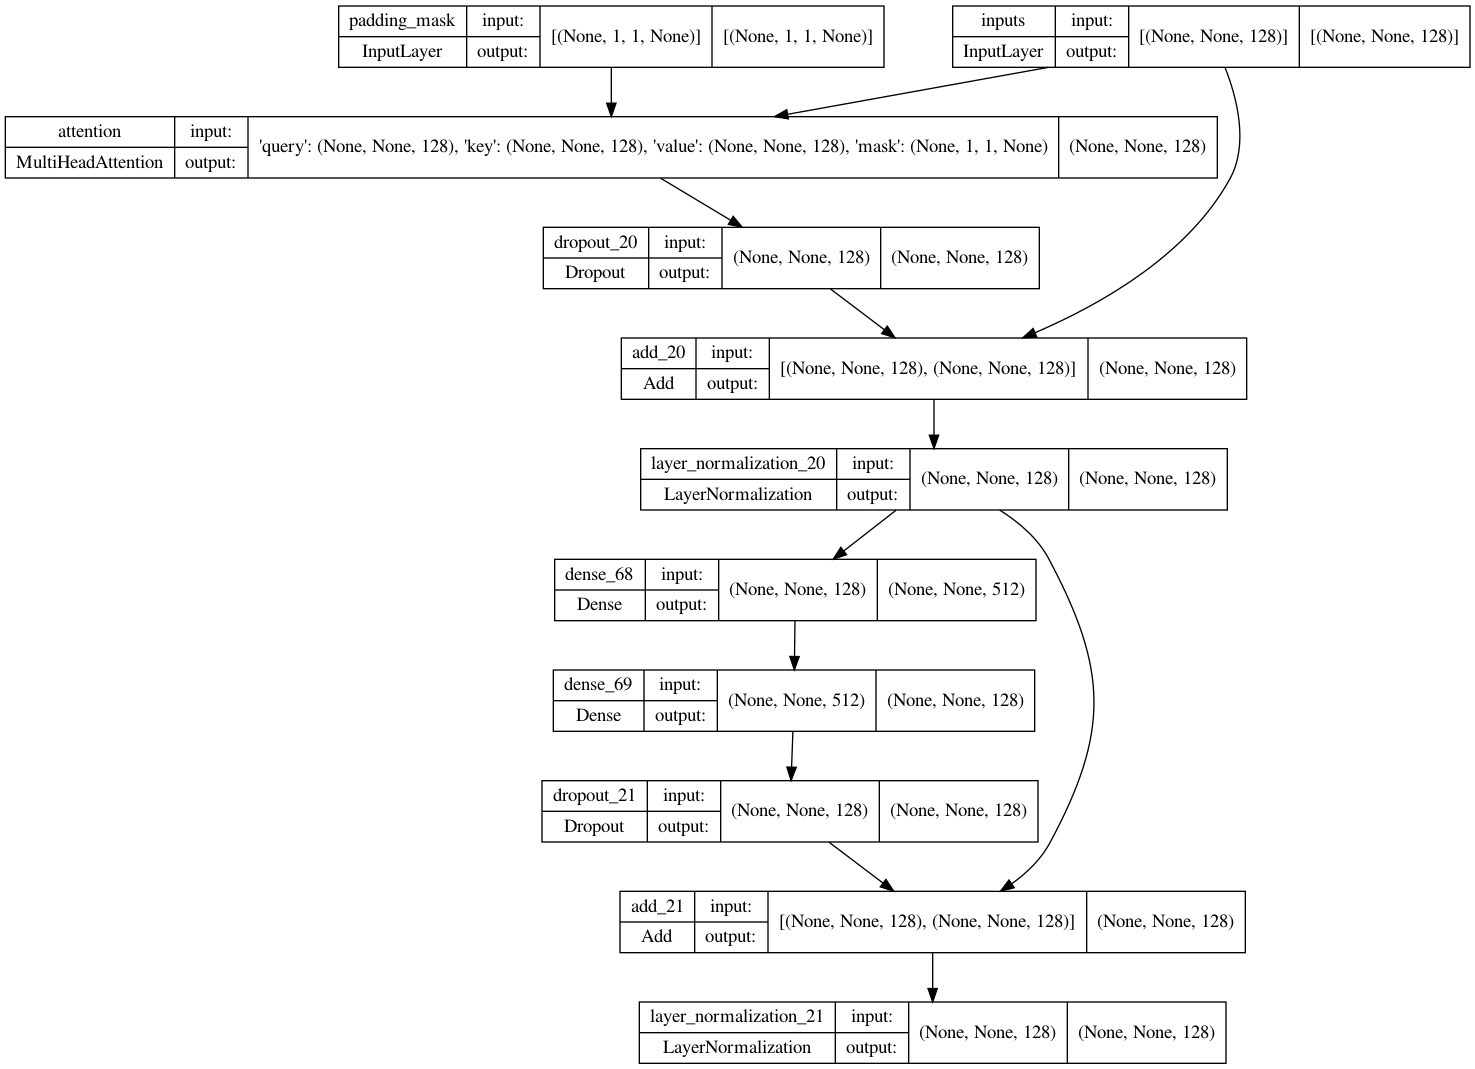

In [118]:
sample_encoder_layer = encoder_layer(
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_encoder_layer")

tf.keras.utils.plot_model(
    sample_encoder_layer, show_shapes=True)

## Encoder

![Encoder](./Mindmap/Encoder.png)

In [119]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.keras.layers.Lambda(lambda d_model: tf.math.sqrt(tf.cast(d_model, tf.float32)))(d_model)
    
    embeddings = PositionalEncoding(vocab_size,d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

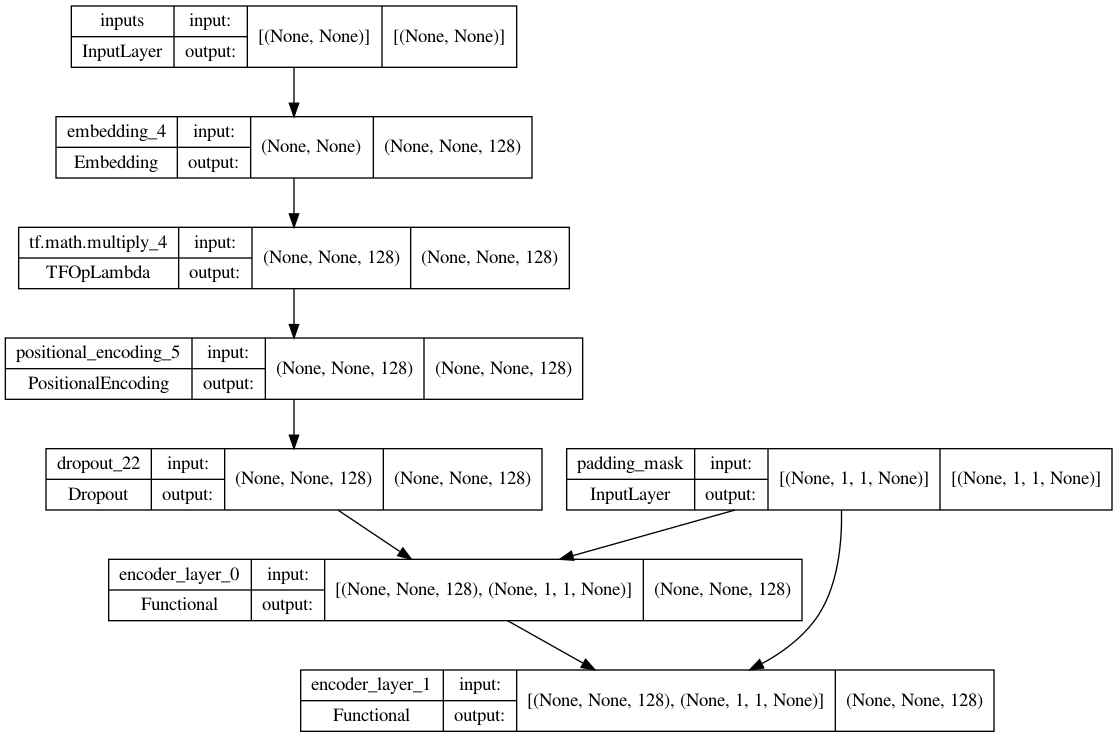

In [120]:
sample_encoder = encoder(
    vocab_size=8192,
    num_layers=2,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_encoder")

tf.keras.utils.plot_model(
   sample_encoder, show_shapes=True)

### Decoder Layer

Each decoder layer consists of sublayers:

1.   Masked multi-head attention (with look ahead mask and padding mask)
2.   Multi-head attention (with padding mask). `value` and `key` receive the *encoder output* as inputs. `query` receives the *output from the masked multi-head attention sublayer.*
3.   2 dense layers followed by dropout


Each of these sublayers has a residual connection around it followed by a layer normalization. The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis.

As `query` receives the output from decoder's first attention block, and `key` receives the encoder output, the attention weights represent the importance given to the decoder's input based on the encoder's output. In other words, the decoder predicts the next word by looking at the encoder output and self-attending to its own output. See the demonstration above in the scaled dot product attention section.


In [121]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': look_ahead_mask
        })
    # input/gradient signal is able to pass back thanks to [inputs,attention] to solve vanishing gradient
    add_attention = tf.keras.layers.add([attention1,inputs])    
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

    attention2 = MultiHeadAttention(
        d_model, num_heads, name="attention_2")(inputs={
            'query': attention1,
            'key': enc_outputs,
            'value': enc_outputs,
            'mask': padding_mask
        })
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    # output/gradient signal is able to pass back thanks to [outputs,attention] to solve vanishing gradient
    add_attention = tf.keras.layers.add([attention2,attention1])
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    # output/gradient signal is able to pass back thanks to [outputs,attention] to solve vanishing gradient
    add_attention = tf.keras.layers.add([outputs,attention2])
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

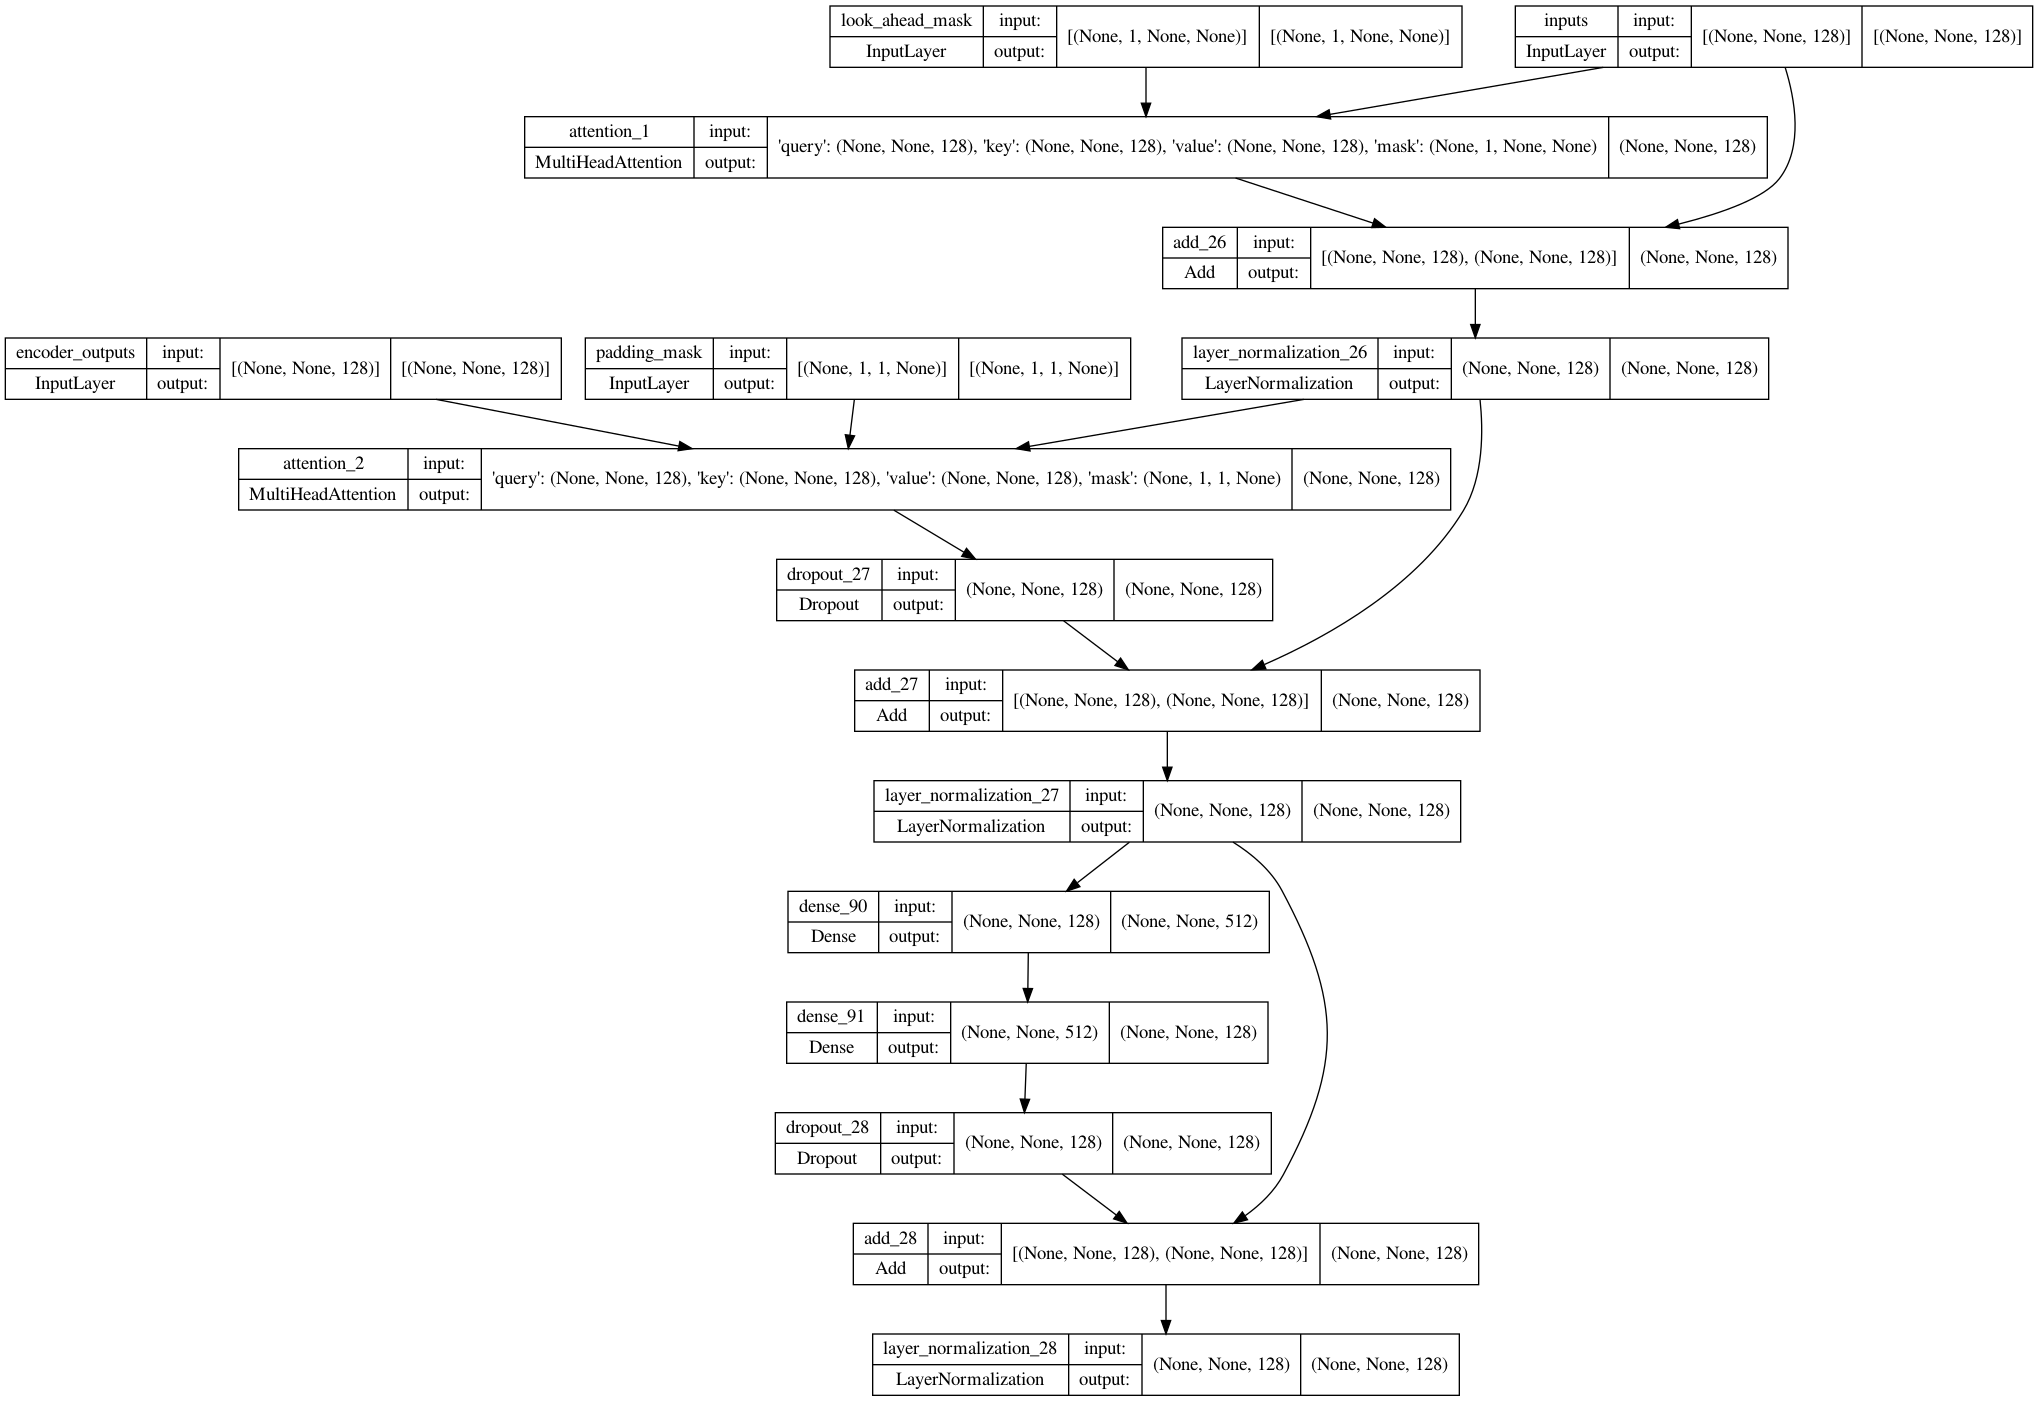

In [122]:
sample_decoder_layer = decoder_layer(
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_decoder_layer")

tf.keras.utils.plot_model(
    sample_decoder_layer, show_shapes=True)

## Decoder
![Decoder](./Mindmap/Decoder.png)


In [123]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name='look_ahead_mask')
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.keras.layers.Lambda(lambda d_model: tf.math.sqrt(tf.cast(d_model, tf.float32)))(d_model)
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

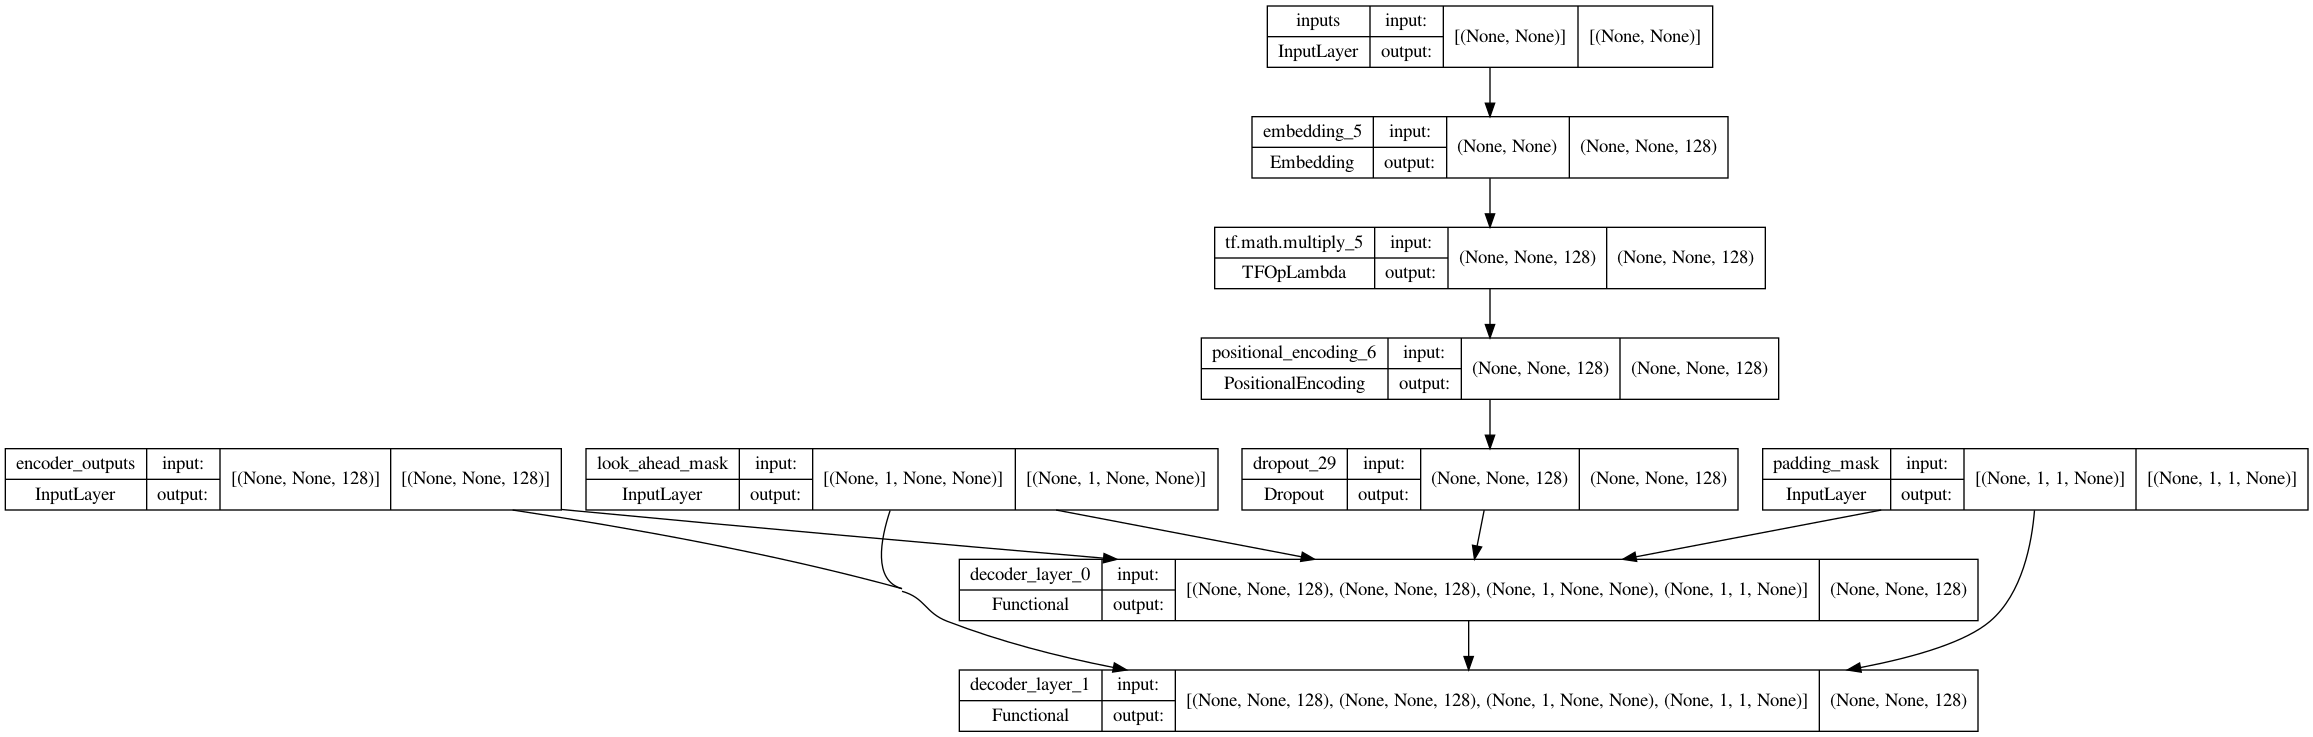

In [124]:
sample_decoder = decoder(
    vocab_size=8192,
    num_layers=2,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_decoder")

tf.keras.utils.plot_model(
    sample_decoder, show_shapes=True)

## Transformer

Transformer consists of:
- the encoder,
- decoder
- and a final linear layer.

The output of the decoder is the input to the linear layer and its output is returned.

In [125]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='enc_padding_mask')(inputs)

    # mask the future tokens for decoder inputs at the 1st attention block
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)

    # mask the encoder outputs for the 2nd attention block
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='dec_padding_mask')(inputs)

    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

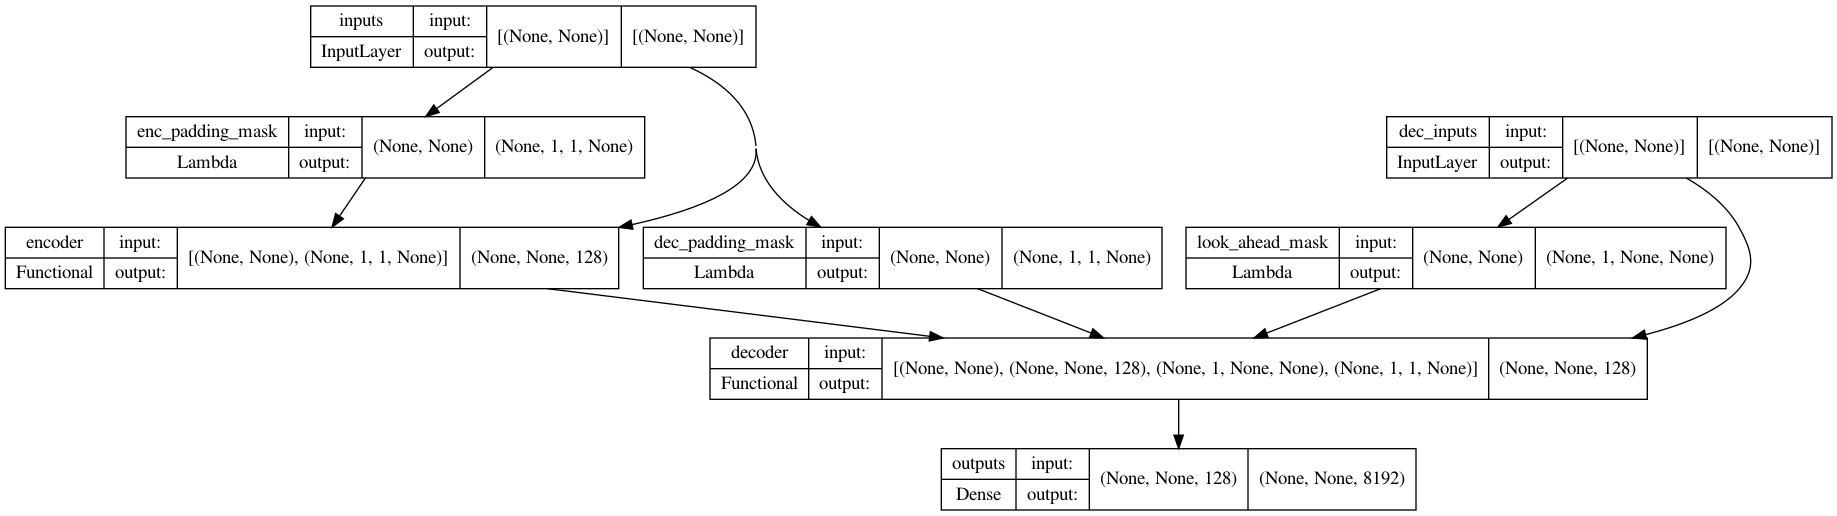

In [126]:
sample_transformer = transformer(
    vocab_size=8192,
    num_layers=4,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_transformer")

tf.keras.utils.plot_model(
    sample_transformer, show_shapes=True)

## Transformer architecture

![Transformer summary](https://codeantenna.com/image/https://img-blog.csdnimg.cn/20210506015017984.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3FxXzMzMzMxNDUx,size_16,color_FFFFFF,t_70#pic_center)

Source: CodeAntenna

## Train Model

### Loss function

As we padded the inputs in the Transformer, we need to use the padding when calculating the loss function.

In [127]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

### Custom learning rate

Use the Adam optimizer with a custom learning rate scheduler as found in the original [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$

In [128]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = tf.constant(d_model,dtype=tf.float32)
        self.warmup_steps = warmup_steps

    def get_config(self):
            return {"d_model": self.d_model,"warmup_steps":self.warmup_steps}

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.multiply(tf.math.rsqrt(self.d_model), tf.math.minimum(arg1, arg2))

4000


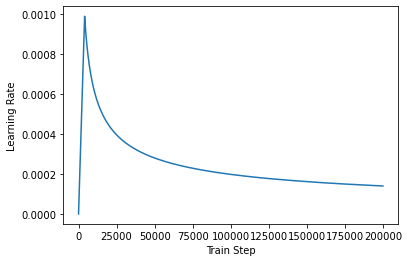

In [206]:
sample_learning_rate = CustomSchedule(d_model=256)

data = sample_learning_rate(tf.range(200000, dtype=tf.float32))
plt.plot(data)
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

print(np.argmax(data))

### Initialize and compile model

Initialize and compile model with our predefined custom learning rate and Adam optimizer under the strategy scope.

In [130]:
# clear backend
tf.keras.backend.clear_session()

learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    # ensure labels have shape (batch_size, MAX_LENGTH - 1)
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

# initialize and compile model within strategy scope
with strategy.scope():
    model = transformer(
        vocab_size=VOCAB_SIZE,
        num_layers=NUM_LAYERS,
        units=UNITS,
        d_model=D_MODEL,
        num_heads=NUM_HEADS,
        dropout=DROPOUT)

    model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 256)    3173632     ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

### Fit model

Train our transformer by simply calling `model.fit()`

In [131]:
#history = model.fit(dataset, epochs=EPOCHS)

### Save model

In [132]:
#model.save_weights(f'Saved{EPOCHS}.h5')

In [133]:
#import pickle
#with open(f'Saved{EPOCHS}HistoryDict', 'wb') as file_pi:
#    pickle.dump(history.history, file_pi)

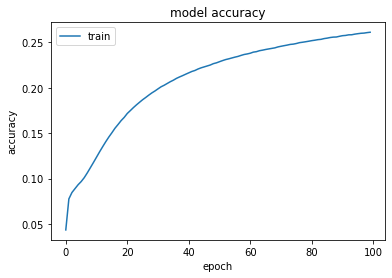

In [134]:
import pickle
with open(f'Saved{EPOCHS}HistoryDict', 'rb') as file_pi:
    history_loaded = pickle.load(file_pi)

plt.plot(history_loaded['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

From the graph above, we see that the model accuracy generally increase over each epoch, converging to around 0.26.

It is worth noticing that the most dramatic increase occurs at around 20 epoch.

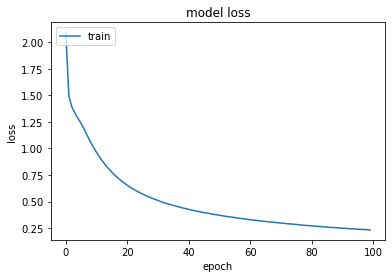

In [135]:
plt.plot(history_loaded['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

We observe that the model loss decreased over each epoch, converging around 0.25.

It is worth noticing that the most dramatic decrease occurs at around 10 epoch.

### Load model

In [136]:
loaded_model = transformer(
                        vocab_size=VOCAB_SIZE,
                        num_layers=NUM_LAYERS,
                        units=UNITS,
                        d_model=D_MODEL,  
                        num_heads=NUM_HEADS,
                        dropout=DROPOUT)

import h5py
with h5py.File(f'Saved{EPOCHS}.h5', 'r') as f:
    loaded_model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
    loaded_model.load_weights(f'Saved{EPOCHS}.h5')

## Predict

To make a prediction,

* Apply the same preprocessing method we used to create our dataset for the input sentence.
* Tokenize the input sentence and add `START_TOKEN` and `END_TOKEN`. 
* Calculate the padding masks and the look ahead masks.
* The decoder then outputs the predictions by looking at the encoder output and its own output.
* Select the last word and calculate the argmax of that.
* Concatentate the predicted word to the decoder input as pass it to the decoder.
* In this approach, the decoder predicts the next word based on the previous words it predicted.

Note: The model used here has less capacity and trained on a subset of the full dataset, hence its performance can be further improved.

In [192]:
def evaluate(sentence, model):
    sentence = preprocess_sentence(sentence)

    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    output = tf.expand_dims(START_TOKEN, 0)

    # one hot encoding
    for i in range(MAX_LENGTH):
        """
        Notice here that Transformer's decoder predicts the next word
        We iterate and feed the previous word into decoder to generate the next word.
        """
        predictions = model(inputs=[sentence, output], training=False)

        # select the last word from the seq_len dimension
        predictions = predictions[:, -1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # return the result if the predicted_id is equal to the end token
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # concatenated the predicted_id to the output which is given to the decoder
        # as its input.
        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0)


def predict(sentence, model):
    prediction = evaluate(sentence, model)

    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size])

    print('Input: {}'.format(sentence))
    print('Output: {}'.format(predicted_sentence))

    return predicted_sentence

In [233]:
prediction = loaded_model(inputs=[tf.expand_dims(START_TOKEN + tokenizer.encode('hi') + END_TOKEN, axis=0), tf.expand_dims(START_TOKEN, 0)], training=False)
print(prediction)
print(np.argmax(prediction))
print(tokenizer.decode([np.argmax(prediction)]))

tf.Tensor(
[[[-14.799138   -5.2938886   0.5950498 ... -14.806442  -14.810995
    -2.7927446]]], shape=(1, 1, 8279), dtype=float32)
428
hi


In [234]:
output = predict('hi', loaded_model)

Input: hi
Output: hi .


### Test model

In [138]:
#output = predict('Welcome!', model)

In [139]:
output = predict('Welcome!', loaded_model)

Input: Welcome!
Output: has nicolet told you any colorful stories like that ?


# Section3: GIF-based chatbot

In [140]:
import giphy_client 

import time
import giphy_client
from giphy_client.rest import ApiException
from pprint import pprint

from IPython.display import HTML, display


# create an instance of the API class
api_instance = giphy_client.DefaultApi()
api_key = 'bSjJ0Q4ZlWkkrRtYm3fdGvP5y5k47mRX' # str | Giphy API Key.
q = 'cheeseburgers' # str | Search query term or prhase.
limit = 25 # int | The maximum number of records to return. (optional) (default to 25)
offset = 0 # int | An optional results offset. Defaults to 0. (optional) (default to 0)
rating = 'g' # str | Filters results by specified rating. (optional)
lang = 'en' # str | Specify default country for regional content; use a 2-letter ISO 639-1 country code. See list of supported languages <a href = \"../language-support\">here</a>. (optional)
fmt = 'json' # str | Used to indicate the expected response format. Default is Json. (optional) (default to json)


In [238]:
# if sentence includes quit, then exit chat:

import random
while True:
    # take user input
    text = input(">> You:")

    # encode the input and add end of string token
    output = predict(text, loaded_model)
    
    api_response = api_instance.gifs_search_get(api_key, output[:limit], limit=limit, offset=offset, rating=rating, lang=lang, fmt=fmt)
    display(HTML(f'''<div style="display: flex; justify-content: row;">
    <img src="{api_response.data[random.randint(0,10)].images.downsized.url}">
    </div>'''))
    
    if "quit" in text.lower() or "bye" in text.lower():
        print('Goodbye')
        break
    
    #print(api_response.data[0].images.downsized.url)

Input: hi
Output: hi .


Input: how are you?
Output: yeah , i would like to have the upsetting for this later .


Input: quit
Output: i have got it . i am just a child psychologist and a into an they taking us .


Goodbye


# Conclusion

Limitation:
- Transformer is a complex model that is memory intensive at training (running out of memory could happen during training)

- Transformer requires a lot of data to achieve good result. For smaller amount of data, other seq-to-seq model (LSTM, RNN) could achieve better result.

- Validation metric is comparing each output word of the model with the sample output, so the model tends to generate sentence at length more or less the same as the movie dialogs.

Challenges:

- Transformer has a lot of hyperparameters to tune (9,002,327), and we know very little about how changing hyperparameters will change the neural network because Transformer is a recently published model


# Works Cited
- "A Transformer Chatbot Tutorial with TensorFlow 2.0" https://blog.tensorflow.org/2019/05/transformer-chatbot-tutorial-with-tensorflow-2.html

- Zuzanna "Chat_bot" https://gitlab.com/Deutschman/chat-bot

- Zuzanna Deutschman "Replicate your friend with Transformer" https://chatbotslife.com/replicate-your-friend-with-transformer-bc5efe3a1596?gi=d63f7ba65a13

- "LSTM is dead. Long Live Transformers!" https://youtube.com/watch?v=S27pHKBEp30

- Amila Viraj "How To Build Your Own Chatbot Using Deep Learning" https://towardsdatascience.com/how-to-build-your-own-chatbot-using-deep-learning-bb41f970e281

- CodeAntenna https://codeantenna.com/a/z7x64EXn78

- Junhup Lim "Optimising your input pipeline performance with tf.data (part 1)" https://towardsdatascience.com/optimising-your-input-pipeline-performance-with-tf-data-part-1-32e52a30cac4?gi=3318ee9c81e1

- Daniel Ibanez "Transformer Text Embeddings" https://www.baeldung.com/cs/transformer-text-embeddings

- "Attention Is All You Need" https://arxiv.org/pdf/1706.03762.pdf

- Jay Alammar "The Illustrated Transformer" https://jalammar.github.io/illustrated-transformer/

- Astha Oriel "Top 10 chatbot datasets assisting in ml and nlp projects" https://www.analyticsinsight.net/top-10-chatbot-datasets-assisting-in-ml-and-nlp-projects/